<a href="https://colab.research.google.com/github/omararh/Expression-editor-assistant/blob/main/phi_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("La version de torch est : ", torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

La version de torch est :  2.6.0+cu124
Le calcul GPU est disponible ?  True


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Import Prompt used data

In [3]:
import json

def read_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    return json.load(f)

INPUT_DATA_BASE_PATH = '/input_data/'

AVAILABLE_CONTEXT = read_file(INPUT_DATA_BASE_PATH + 'context.json')

SYMFONY_EXAMPLES = read_file(INPUT_DATA_BASE_PATH + 'examples.json')

# Embedding to filter the prompt data



In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import spacy
!python -m spacy download fr_core_news_md

# Load french tokenizer, tagger, parser
nlp = spacy.load('fr_core_news_md')

def get_embedding(text):
    """
    Get normalized average embedding of all tokens (filtered).
    """
    doc = nlp(text)
    vectors = np.array([token.vector for token in doc if token.has_vector and not token.is_stop and not token.is_punct])

    if len(vectors) == 0:
        return np.zeros((nlp.vocab.vectors_length,))

    avg_vector = np.mean(vectors, axis=0)
    return avg_vector / np.linalg.norm(avg_vector)


def filter_by_embedding(input, dict, top_k=5):
    """
    return K relevant examples from the examples list
    Args:
        input: user request
        dict: (description -> key) examples
        top_k: K relevant examples to be returned

    Returns:
        K relevant examples
    """
    input_embedding = get_embedding(input)

    similarities = []

    for description, key in dict.items():
        desc_embedding = get_embedding(description)

        similarity = cosine_similarity([input_embedding], [desc_embedding])[0][0]
        similarities.append((similarity, description, key))

    similarities.sort(reverse=True)
    top_examples = [(desc, expr) for _, desc, expr in similarities[:top_k]]

    return top_examples


def calculate_similarity(expected, generated):
    """

    """
    # Vérifier l'égalité exacte
    if expected == generated or expected.strip() == generated.strip():
        return 1.0

    # Similarité par embedding
    expected_embedding = get_embedding(expected)
    generated_embedding = get_embedding(generated)

    # Fallback si problème d'embedding
    if not expected_embedding.any() or not generated_embedding.any():
        expected_words = set(expected.split())
        generated_words = set(generated.split())
        return len(expected_words.intersection(generated_words)) / len(expected_words) if expected_words else 0.0

    return float(cosine_similarity([expected_embedding], [generated_embedding])[0][0])


 # Prompt Functions

In [13]:
def generate_expression(user_intent, available_context=None, examples=None, max_retries=1):
    """
    Génère une suggestion d'expression Symfony avec retry en cas d'échec
    Args:
        user_intent (str): Intention ou question de l'utilisateur
        available_context (dict, optional): Contexte disponible dans l'éditeur
        examples (list, optional): Exemples d'expressions valides
        max_retries (int, optional): Nombre maximal de tentatives en cas d'erreur
    Returns:
        str: Expression Symfony suggérée par le modèle
    """
    # Construction du prompt pour Phi-3
    prompt = _build_prompt(user_intent, available_context, examples)

    retries = 0
    while retries <= max_retries:
        try:
            # Génération et traitement de la réponse
            response = _generate_and_process_response(prompt)

            # Vérification que la réponse n'est pas vide
            if _is_valid_response(response):
                return response
            else:
                # Si réponse vide ou invalide, retenter
                retries = _handle_retry(retries, max_retries, "Réponse vide ou invalide")
        except Exception as e:
            # En cas d'erreur, retenter
            retries = _handle_retry(retries, max_retries, f"Erreur lors de la génération: {e}")

    # Si après toutes les tentatives, rien n'a fonctionné
    return "Une erreur est survenue, veuillez réessayer."


def _build_prompt(user_intent, available_context, examples):
    """Construit un prompt clair et minimaliste pour le modèle Phi-3"""

    prompt = (
        "Tu es un assistant expert en Symfony Expression Language. "
        "Ta tâche est de générer une **seule** expression Symfony valide, sans aucune explication, "
        "en te basant uniquement sur le contexte et les exemples fournis.\n\n"
    )

    # Contexte disponible
    if available_context:
        prompt += "Contexte :\n"
        for category, items in available_context:
            prompt += f"- {category} : {', '.join(items)}\n"
        prompt += "\n"

    # Exemples pertinents
    if examples:
        prompt += "Exemples :\n"
        for description, expression in examples:
            prompt += f"Demande : {description}\n"
            prompt += f"Expression : {expression}\n\n"

    # Ajout de l’intention actuelle de l’utilisateur
    prompt += f"Demande : {user_intent.strip()}\n"
    prompt += "Expression :"

    return prompt

def _generate_and_process_response(prompt):
    """Génère une réponse et extrait la partie pertinente"""
    # Encoder le prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Minimized parameters
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,         #
        do_sample=False,           #
        num_beams=1,               #
        top_p=None,                #
        eos_token_id=tokenizer.eos_token_id
    )

    # Décodage de la sortie
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraction de la partie pertinente
    return _extract_response(full_response, prompt)


def _extract_response(full_response, prompt):
    response = full_response.replace(prompt, "").strip()

    # Supprime les sections parasites si présentes
    for unwanted in ["###", "[", "]", "Contexte", "Réponse", "Explication", "Analyse"]:
        if unwanted.lower() in response.lower():
            response = response.split("\n")[0].strip()
            break

    # Extrait à partir de "Expression Symfony:" si possible
    if "Expression Symfony:" in full_response:
        response = full_response.split("Expression Symfony:")[-1].strip()

    # Nettoyage supplémentaire
    if "\n" in response:
        response = response.split("\n")[0].strip()

    return response

def _is_valid_response(response):
    """Vérifie si la réponse est valide"""
    return response and not response.isspace() and "```" not in response


def _handle_retry(retries, max_retries, error_message):
    """Gère la logique de retry et renvoie le nouveau compteur"""
    retries += 1
    print(f"{error_message}, tentative {retries}/{max_retries+1}...")

    # Attendre un peu avant de retenter
    import time
    time.sleep(1)

    return retries

# Prompt

In [16]:
user_query_2 = "Vérifier si l'utilisateur a le droit d'éditer des fichiers"
inverted_examples = {v: k for k, v in SYMFONY_EXAMPLES.items()}
relevant_examples = filter_by_embedding(user_query_2, inverted_examples, top_k=5)

inverted_context = {v: k for k, v in SYMFONY_EXAMPLES.items()}
context = filter_by_embedding(user_query_2, inverted_context, top_k=5)

result_2 = generate_expression(user_query_2, context, relevant_examples)
print("Résultat:")
print(result_2)

Résultat:
legacyContext.contextVar.userAccessLevels contains 'editor'


# Test

Époque 1/5...
Précision: 100.00%
Époque terminée en 99.44s

Époque 2/5...
Précision: 100.00%
Époque terminée en 99.06s

Époque 3/5...
Précision: 100.00%
Époque terminée en 98.82s

Époque 4/5...
Précision: 100.00%
Époque terminée en 98.40s

Époque 5/5...
Précision: 100.00%
Époque terminée en 98.42s

Temps total: 494.16s
Taux de correspondance moyen: 100.00%
Similarité moyenne: 98.39%


,query,expected,best_generated,avg_similarity,match_rate
0,Vérifier si le nom d'utilisateur est égal à 't...,legacyContext.contextVar.userName == 'toto',legacyContext.contextVar.userName == 'toto',1.000000,1.0
1,Exécuter le modèle 'IPC_USER_PROFILE' et si le...,getModelValue('IPC_USER_PROFILE') || false,getModelValue('IPC_USER_PROFILE') || false,1.000000,1.0
2,Vérifier si l'utilisateur peut mettre à jour l...,documentAccessUpdateData() and today() == '200...,documentUpdateData() and today() == '2020-03-26',0.981083,1.0
3,Vérifier si l'email de l'utilisateur contient ...,legacyContext.contextVar.userEmail matches '/@...,legacyContext.contextVar.userEmail matches '@i...,1.000000,1.0
4,"Pour chaque ligne du document, vérifier si le ...",row.status == 'pending',row.status == 'pending',1.000000,1.0
5,Vérifier si l'utilisateur est un manager et pe...,"inArray('manager', legacyContext.contextVar.us...","inArray('manager', legacyContext.contextVar.us...",1.000000,1.0
6,Vérifier si l'email suit le format prenom.nom@...,legacyContext.contextVar.userEmail matches '/^...,legacyContext.contextVar.userEmail matches '/^...,1.000000,1.0
7,Vérifier si la langue courante est le français...,legacyContext.contextVar.currentLanguage in ['...,legacyContext.contextVar.currentLanguage in ['...,1.000000,1.0
8,Vérifier si l'utilisateur a plus de 3 niveaux ...,legacyContext.contextVar.userAccessLevels|leng...,legacyContext.contextVar.userAccessLevels|leng...,1.000000,1.0
9,"Pour chaque ligne, vérifier si le statut est '...","row.status in ['active', 'pending'] and isEmpt...","row.status in ['active', 'pending'] and isEmpt...",1.000000,1.0


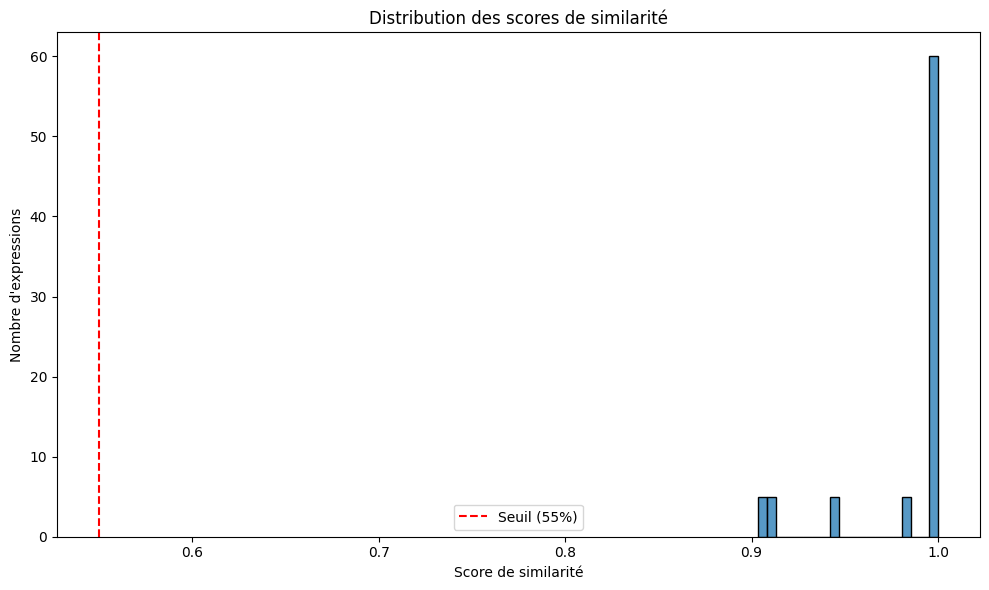

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

TEST_RESULTS_PATH = "testResults/"

def setup_test_dir():
    """Crée le répertoire de résultats"""
    os.makedirs(TEST_RESULTS_PATH, exist_ok=True)

def process_test_case(test, context, examples, similarity_threshold):
    """
    Traite un cas de test unique

    Args:
        test: Le cas de test à traiter
        context: Le contexte disponible
        examples: Les exemples d'expressions
        similarity_threshold: Seuil de similarité

    Returns:
        dict: Résultat du test
    """
    # Génération et mesure du temps
    start_time = time.time()
    try:
        generated = generate_expression(
            test['query'],
            available_context=context,
            examples=examples
        )
    except Exception as e:
        print(f"Erreur: {str(e)[:100]}...")
        generated = "Erreur API"

    execution_time = time.time() - start_time

    # Calcul des métriques
    similarity = calculate_similarity(test['expected'], generated)
    is_match = similarity >= similarity_threshold

    # Construction du résultat
    return {
        'query': test['query'],
        'expected': test['expected'],
        'generated': generated,
        'similarity': similarity,
        'is_match': is_match,
        'execution_time': execution_time
    }

def write_result_to_file(f, result):
    """
    Écrit un résultat dans un fichier

    Args:
        f: Le fichier ouvert en écriture
        result: Le résultat à écrire
    """
    f.write(f"Query: {result['query']}\n")
    f.write(f"Expected: {result['expected']}\n")
    f.write(f"Generated: {result['generated']}\n")
    f.write(f"Similarité: {result['similarity']:.2%}\n")
    f.write(f"Résultat: {'✅ Match' if result['is_match'] else '❌ No Match'}\n\n")

def calculate_epoch_metrics(epoch_results):
    """
    Calcule les métriques pour une époque

    Args:
        epoch_results: Les résultats de l'époque

    Returns:
        float: Le taux de correspondance
    """
    epoch_df = pd.DataFrame(epoch_results)
    return epoch_df['is_match'].mean() if not epoch_df.empty else 0

def generate_visualizations(all_results, epoch_times, similarity_threshold, epochs):
    """
    Génère les visualisations des résultats

    Args:
        all_results: Tous les résultats de test
        epoch_times: Temps d'exécution par époque
        similarity_threshold: Seuil de similarité
        epochs: Nombre d'époques
    """
    all_df = pd.DataFrame(all_results)

    # 1. Graphique de distribution des similarités
    plt.figure(figsize=(10, 6))
    sns.histplot(data=all_df, x='similarity', bins=20)
    plt.axvline(x=similarity_threshold, color='red', linestyle='--',
                label=f'Seuil ({similarity_threshold:.0%})')
    plt.title('Distribution des scores de similarité')
    plt.xlabel('Score de similarité')
    plt.ylabel("Nombre d'expressions")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{TEST_RESULTS_PATH}distribution_similarite.png")

def calculate_average_results(query_results):
    """
    Calcule les résultats moyens par requête

    Args:
        query_results: Dictionnaire des résultats par requête

    Returns:
        DataFrame: Résultats moyens
    """
    avg_results = []

    for query, results in query_results.items():
        # Trouver le meilleur résultat
        best_result = max(results, key=lambda x: x['similarity'])

        # Calculer les moyennes
        similarities = [r['similarity'] for r in results]
        is_matches = [r['is_match'] for r in results]

        avg_results.append({
            'query': query,
            'expected': best_result['expected'],
            'best_generated': best_result['generated'],
            'avg_similarity': np.mean(similarities),
            'match_rate': np.mean(is_matches)
        })

    return pd.DataFrame(avg_results)

def run_tests(context, examples, similarity_threshold=0.55, epochs=5):
    setup_test_dir()

    all_results = []
    epoch_times = []
    start_total = time.time()

    query_results = {}

    for epoch in range(1, epochs + 1):
        print(f"Époque {epoch}/{epochs}...")
        start_epoch = time.time()

        epoch_results = []
        with open(f"{TEST_RESULTS_PATH}resultats_epoch_{epoch}.txt", "w", encoding="utf-8") as f:
            for test in test_cases:
                user_query = test['query']

                # Contexte et exemples filtrés dynamiquement
                filtred_examples = filter_by_embedding(user_query, {v: k for k, v in examples.items()}, top_k=10)
                filtred_context = filter_by_embedding(user_query, {v: k for k, v in context.items()}, top_k=5)

                result = process_test_case(
                    test, filtred_context, filtred_examples, similarity_threshold
                )

                query = test['query']
                if query not in query_results:
                    query_results[query] = []
                query_results[query].append(result)

                all_results.append(result)
                epoch_results.append(result)

                write_result_to_file(f, result)

        duration = time.time() - start_epoch
        epoch_times.append(duration)

        match_rate = calculate_epoch_metrics(epoch_results)
        print(f"Précision: {match_rate:.2%}")
        print(f"Époque terminée en {duration:.2f}s\n")

    total_time = time.time() - start_total
    print(f"Temps total: {total_time:.2f}s")

    avg_df = calculate_average_results(query_results)
    avg_df.to_csv(f"{TEST_RESULTS_PATH}resultats_moyens.csv", index=False)

    print(f"Taux de correspondance moyen: {avg_df['match_rate'].mean():.2%}")
    print(f"Similarité moyenne: {avg_df['avg_similarity'].mean():.2%}")

    generate_visualizations(all_results, epoch_times, similarity_threshold, epochs)

    return avg_df

# Utilisation
test_cases = read_file('/test_data/test_cases.json')
run_tests(AVAILABLE_CONTEXT, SYMFONY_EXAMPLES, epochs=5)